In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from data_reconstruct import *
from data_reconstruct.backend import *
from data_reconstruct.examples import *
from data_reconstruct.utilities import *

In [3]:
random_state = 42
np.random.seed(random_state)

# Load Data

In [4]:
# Read
mod1 = pd.read_csv('data/decennial_2020_nov8GAN.csv')[1:]
mod2 = pd.read_csv('data/public_150k_plus_210630.csv')
mod1_tagged = process_decennial(mod1)
mod2_tagged = process_ppp(mod2)
mod1, mod1_cols, mod1_tags_cols = mod1_tagged
mod2, mod2_cols, mod2_tags_cols = mod2_tagged

# Merge
mod1, mod2, annotations = merge_data(mod1_tagged, mod2_tagged, agg_by_tag=True)

# Sample
num_samples = min(mod1.shape[0], 2000)
mod1_sample = mod1.sample(num_samples, random_state=random_state)
mod2_sample = mod2.sample(num_samples, random_state=random_state)
annotations_sample = annotations.sample(num_samples, random_state=random_state);

# Generate Merged Anonymous Records

In [5]:
anonymized_data = anonymize(
    mod1_sample.to_numpy(),
    mod2_sample.to_numpy(),
    embedding_dim=10,
    embedding_kwargs={
        'project_mode': 'tsne',
        'epoch_pd': 1000,
        'log_pd': 200,
        'epoch_DNN': 100,
        'log_DNN': 100,
    },
)

use random seed: 666
Shape of Raw data
Dataset 0: (729, 6)
Dataset 1: (729, 4)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[200/1000] err:0.4023 alpha:1.1304
epoch:[400/1000] err:0.1626 alpha:0.4578
epoch:[600/1000] err:0.1996 alpha:0.5643
epoch:[800/1000] err:0.2308 alpha:0.6561
epoch:[1000/1000] err:0.2571 alpha:0.7368
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[100/100]: loss:3.316516, align_loss:0.509335
Done
---------------------------------
unionCom Done!
time: 19.974509716033936 seconds


# Preview Results

In [6]:
pd.DataFrame(anonymized_data[0], index=annotations_sample.iloc[:, 0])

,0,1,2,3,4,5,6,7,8,9
ProjectCountyName,,,,,,,,,,
NESHOBA,2.891493,-1.977890,-1.353238,1.965140,-2.156263,-1.907313,-1.972180,-0.450202,-2.445357,-2.255031
CLEVELAND,-1.806849,0.811407,-0.080906,-1.815551,0.530689,0.642399,0.302727,-0.462854,1.208565,1.760480
HUMBOLDT,-0.787833,0.000231,0.256909,-0.829869,-0.440409,0.331436,0.053342,0.584466,-0.011021,0.478801
LAKE,-1.145615,-0.214830,-0.232433,-0.829827,-0.753118,0.003020,-0.637637,0.049623,0.391772,0.357780
PENOBSCOT,-0.244805,-2.859722,2.096595,-1.787663,0.015580,1.482375,0.358948,2.675474,0.275013,-1.109564
...,...,...,...,...,...,...,...,...,...,...
BRAZOS,1.817484,-1.344863,-0.654994,1.062701,-1.291620,-1.108390,-0.939807,0.086791,-1.673230,-1.497638
CASCADE,-0.686213,-0.848294,1.034363,-1.167623,-0.474307,0.833560,0.212677,1.533907,-0.082424,0.046614
GUADALUPE,1.869251,-2.584731,-0.045858,0.870094,-1.522159,-0.712031,-1.036330,1.174830,-1.660301,-2.206576


# Usability

## Arbitrary Statistic Prediction

In [7]:
target = np.sqrt(mod1_sample['totalpop_other'] * mod2_sample['HEALTH_CARE_PROCEED']).to_numpy().reshape((-1, 1))
source_raw = pd.concat([mod1_sample, mod2_sample], axis=1).to_numpy().astype(np.float32)
source = anonymized_data[0]

### Before Anonymization

Epoch:  50    Loss:  0.00134


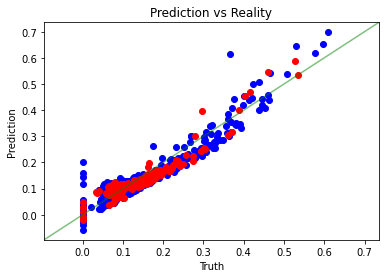

In [8]:
prediction, split_idx = predict_from_data(source_raw, target, nn_kwargs={'epochs': 50})
plot_example_results(target, prediction, split_idx=split_idx)

### After Anonymization (10 Anonymous Features)

Epoch:  50    Loss:  0.00457


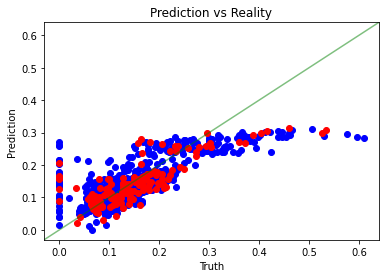

In [9]:
prediction, split_idx = predict_from_data(source, target, nn_kwargs={'epochs': 50})
plot_example_results(target, prediction, split_idx=split_idx)